# MovieLens Recommendation System - Exploratory Data Analysis

# Questions
* What is the distribution of movie ratings?
* Most frequently rated movies?
* Highest and lowest rated movies?
* What are the most common movie genres?

# 1. Imports

In [1]:
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing, feature engineering, and similarity
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# string matching
from fuzzywuzzy import process

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Load Data
Dataset: https://grouplens.org/datasets/movielens/

In [2]:
movies = pd.read_csv('/Users/kevintie/Desktop/data_projects/projects/movie_rec_project/data/ml-latest-small/movies.csv')
ratings = pd.read_csv('/Users/kevintie/Desktop/data_projects/projects/movie_rec_project/data/ml-latest-small/ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


From the data, the key features I will explore further are: rating (collaborate filtering) and genre (content-based filtering).

# 3. Exploratory Data Analysis

In [5]:
n_ratings = len(ratings.rating)
n_movies = ratings.movieId.nunique()
n_users = ratings.userId.nunique()

print(f'Number of ratings: {n_ratings}')
print(f'Number of movies: {n_movies}')
print(f'Number of users: {n_users}')
print(f'Average number of ratings per user: {round(n_ratings / n_users, 2)}')
print(f'Average number of ratings per movie: {round(n_ratings / n_movies, 2)}')

Number of ratings: 100836
Number of movies: 9724
Number of users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


This is a pretty dense dataset ideal for learning purposes. In a real-world scenario, the data would be much more sparse with only a couple viewer interactions.

### Distribution of movie ratings

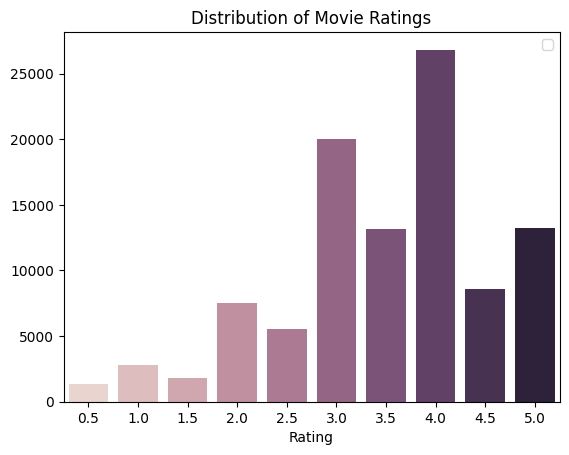

In [6]:
# visualize distribution of movie ratings
sns.countplot(x='rating', data=ratings, hue='rating')

# format visual
plt.xlabel('Rating')
plt.ylabel('')
plt.legend('')
plt.title('Distribution of Movie Ratings')

plt.show()

In [7]:
# determine mean, median, and mode per movie
mean = round(ratings.groupby('movieId')['rating'].mean().mean(), 2)
median = round(ratings.groupby('movieId')['rating'].median().median(), 2)
mode = round(ratings.rating.mode()[0], 2)

print(f'Mean rating per movie: {mean}')
print(f'Median rating per movie: {median}')
print(f'Mode rating per movie: {mode}')

Mean rating per movie: 3.26
Median rating per movie: 3.5
Mode rating per movie: 4.0


In [8]:
# determine mean rating per user
rating_per_user = round(ratings.groupby('userId')['rating'].mean(), 2)
print(f'Mean rating per user: {round(rating_per_user.mean(), 2)}')

Mean rating per user: 3.66


Negative skew towards higher ratings suggest that viewers may choose to rate a title if they really enjoyed it. 

### Most frequently rated movies

First, merge movies and ratings df to access titles.


In [9]:
# merge movie and ratings df
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


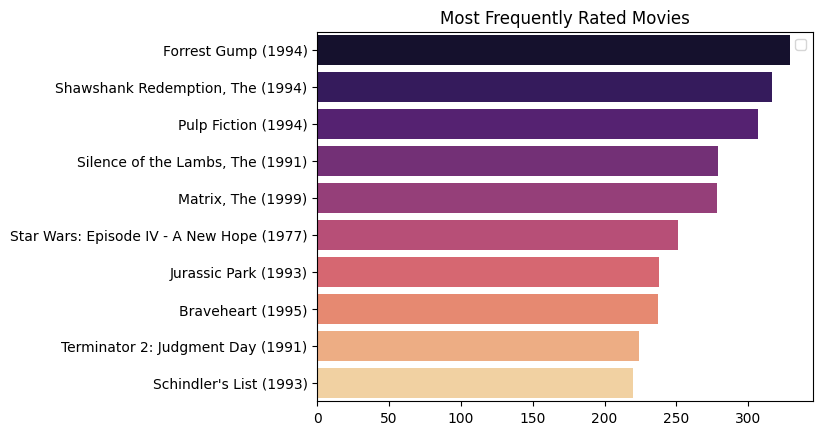

In [10]:
# store title and frequency data into a dataframe
count_df = pd.DataFrame((movie_ratings.title.value_counts()[:10])).reset_index()
count_df.columns = ['title', 'count']

# visualize most frequently rated movies
sns.barplot(x= 'count', y='title', data=count_df, palette='magma')

# format visual
plt.xlabel('')
plt.ylabel('')
plt.legend('')
plt.title('Most Frequently Rated Movies')

plt.show()

Most frequently rated movies are Forrest Gump, Shawshank Redemption, and Pulp Fiction. We can also use the merged ratings data to find highest and lowest rated movies.

### What are the highest/lowest rated movies?

In order to find highest and lowest rated movie, we need to be mindful of any bias in the dataset (i.e. if a movie is highly rated but doesn't a significant number of ratings).

In [11]:
# find the highest rated movie
mean_rating = ratings.groupby('movieId')[['rating']].mean()
highest_rated = mean_rating['rating'].idxmax()

# retreve highest rated movie
movie_ratings[movie_ratings.movieId == highest_rated]

,userId,movieId,rating,timestamp,title,genres
13368,85,53,5.0,889468268,Lamerica (1994),Adventure|Drama
96115,603,53,5.0,963180003,Lamerica (1994),Adventure|Drama


Lamerica is the highest rated movie, but it only has 2 ratings and isn't enough ratings to reliably say it's a good movie.

In [12]:
# find the lowest rated movie
lowest_rated = mean_rating['rating'].idxmin()

# retrieve lowest rated movie
movie_ratings[movie_ratings.movieId == lowest_rated]

,userId,movieId,rating,timestamp,title,genres
13633,89,3604,0.5,1520408880,Gypsy (1962),Musical


Gypsy is the lowest rated movie. Similar to Lamerica, it only has 1 rating, which isn't enough to reliably say it's a bad movie. A better approach to getting a more unbiased result would be to use the Bayesian average.

### Bayesian Average

The Bayesian Average is a weighted approach to calculate a movie's rating, using the global mean rating (m) and the average number of ratings across all movies (C) to weight ratings accordingly for movies with few reviews to many reviews. It is defined as:
$$r_{i} = \frac{C \times m + \sum{reviews}}{C + N}$$

\begin{align*}
r & \text{ - movie's rating} \\
C & \text{ - average number of ratings per movie} \\
m & \text{ - average rating across all movies (global mean rating)} \\
N & \text{ - total number of ratings for movie } i
\end{align*}

Retrieve C and m values.

In [13]:
# first, create a dataframe containing the necessary statistics
movie_stats = pd.DataFrame(ratings.groupby('movieId')['rating'].agg(['count', 'mean']))
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [14]:
# next, create a function that returns the Bayesian average of the dataset
def bayesian_avg(rating):

    '''

    FUNCTION: Calculate the Bayesian average based on a series of ratings for a movie

    ARGS: 
    rating - rating(s) for a movie

    RETURN: 
    scalar

    '''

    # set C and m values
    C = movie_stats['count'].mean()
    m = movie_stats['mean'].mean()

    # calculate Bayesian average based on inputted ratings
    bayesian_avg = (C * m + rating.sum()) / (C + rating.count())

    return round(bayesian_avg, 2)


Apply Bayesian Average across the whole dataset.

In [16]:
# create a dataframe of bayesian averages
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg_rating']

# merge bayesian_avg_ratings with movie_stats
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
# merge movie_stats dataframe with movies to access titles
movie_stats = movie_stats.merge(movies, on='movieId')

movie_stats.head()

,movieId,count,mean,bayesian_avg_rating,title,genres
0,1,215,3.920930,3.89,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,110,3.431818,3.42,Jumanji (1995),Adventure|Children|Fantasy
2,3,52,3.259615,3.26,Grumpier Old Men (1995),Comedy|Romance
3,4,7,2.357143,2.90,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,49,3.071429,3.10,Father of the Bride Part II (1995),Comedy


### Highest rated movies based on Bayesian averages

In [17]:
# retrieve highest rated movies
movie_stats.sort_values(by='bayesian_avg_rating', ascending=False).head()

,movieId,count,mean,bayesian_avg_rating,title,genres
277,318,317,4.429022,4.39,"Shawshank Redemption, The (1994)",Crime|Drama
659,858,192,4.289062,4.24,"Godfather, The (1972)",Crime|Drama
2224,2959,218,4.272936,4.23,Fight Club (1999),Action|Crime|Drama|Thriller
224,260,251,4.231076,4.19,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
921,1221,129,4.259690,4.19,"Godfather: Part II, The (1974)",Crime|Drama


The highest rated movies are Shawshank Redemption, Godfather, and Fight Club. This makes more sense as these are films with higher critical acclaim and press.

### Lowest rated movies based on Bayesian averages

In [18]:
# retrieve lowest rated movies
movie_stats.sort_values(by='bayesian_avg_rating').head()

,movieId,count,mean,bayesian_avg_rating,title,genres
1172,1556,19,1.605263,2.19,Speed 2: Cruise Control (1997),Action|Romance|Thriller
2679,3593,19,1.657895,2.22,Battlefield Earth (2000),Action|Sci-Fi
1372,1882,33,1.954545,2.27,Godzilla (1998),Action|Sci-Fi|Thriller
1144,1499,27,1.925926,2.30,Anaconda (1997),Action|Adventure|Thriller
1988,2643,16,1.687500,2.31,Superman IV: The Quest for Peace (1987),Action|Adventure|Sci-Fi


The lowest rated movies are Speed 2, Battlefield Earth, and Godzilla. Godzilla has a 1 of 5 score on Rotten Tomatoes -- yikes. 

## Movie Genre

A glance at the movie genre data tells us it needs to be cleaned in 2 ways:

1. genre strings contain pipes ('|') and need to be split
2. movie titles end with year, which can instead be extracted as another feature (feature engineering)

In [19]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
# split pipes in genre strings
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Movie genre stats

In [21]:
genre_count = Counter(g for genres in movies['genres'] for g in genres)
print(f'Number of movies genres: {len(genre_count)}')
print(f'Most frequent genres: \n{genre_count.most_common(5)}')

Number of movies genres: 20
Most frequent genres: 
[('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


### Visualize most common genres

In [22]:
# store genre frequencies into a dataframe
genre_counts_df = pd.DataFrame([genre_count]).T.reset_index()
genre_counts_df.columns = ['genre', 'count']

genre_counts_df.head()

,genre,count
0,Adventure,1263
1,Animation,611
2,Children,664
3,Comedy,3756
4,Fantasy,779


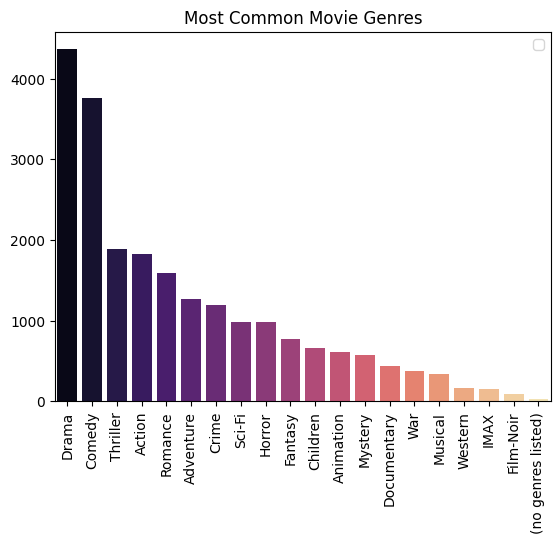

In [23]:
# create a barplot showing most common genres
sns.barplot(x='genre', y='count', data=genre_counts_df, order=genre_counts_df.sort_values(by='count', ascending=False)['genre'], palette='magma')

# rotate plot
plt.xticks(rotation=90)

# format plot
plt.xlabel('')
plt.ylabel('')
plt.legend('')
plt.title('Most Common Movie Genres')

plt.show()

The most common movie genres are: Drama, Comedy, and Thriller.